In [1]:
from google.colab import drive
drive.mount('/content/drive/')
dirpath = '/content/drive/MyDrive/CS5242/Project/Data/'

# WBC: 575 * 575
# pRCC: 2000 * 2000
# CAM16: 384 * 384

Mounted at /content/drive/


In [2]:
# import libs
import pandas as pd
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization


import matplotlib.image as mpimg
%matplotlib inline

In [29]:
# Define needed variables

IMG_WIDTH=224
IMG_HEIGHT=224
batch_size=8
CAM_SIZE = 224
# torch.manual_seed(42)
tf.random.set_seed(0)
np.random.seed(0)
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
masks_paths = [r'WBC_1/mask/',r'WBC_10/mask/',r'WBC_50/mask/',r'WBC_100/train/mask/']
WBC_num = [r'WBC_1',r'WBC_10',r'WBC_50',r'WBC_100/train/']

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.2,
                                     rotation_range=65,
                                     shear_range=0.09,
                                     horizontal_flip=True,
                                     vertical_flip=True)

val_dir =  dirpath + r'WBC_100/val/'
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='sparse')

pre_train_dir = dirpath + r'CAM16_100cls_10mask/train/data/'
pre_val_dir = dirpath + r'CAM16_100cls_10mask/val/data/'
pre_test_dir = dirpath + r'CAM16_100cls_10mask/test/data/'

pre_train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=pre_train_dir,
                                                     shuffle=True,
                                                     target_size=(CAM_SIZE, CAM_SIZE),
                                                     class_mode='sparse')

pre_val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=pre_val_dir,
                                                     shuffle=True,
                                                     target_size=(CAM_SIZE, CAM_SIZE),
                                                     class_mode='sparse')

pre_test_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=pre_test_dir,
                                                     shuffle=True,
                                                     target_size=(CAM_SIZE, CAM_SIZE),
                                                     class_mode='sparse')

Found 1728 images belonging to 5 classes.
Found 757 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


In [ ]:
# Pre process mask images
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
masks_paths = [r'WBC_1/mask/',r'WBC_10/mask/',r'WBC_50/mask/',r'WBC_100/train/mask/']
WBC_num = [r'WBC_1',r'WBC_10',r'WBC_50',r'WBC_100/train/']

def is_image_file(filename):
    supported_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    file_extension = os.path.splitext(filename)[1].lower()
    return file_extension in supported_extensions

for i in range(len(WBCs)):
  data_dir_path = os.path.join(dirpath,WBCs[i]) #/Project/Data/WBC_1/data/
  # print(data_dir_path)
  mask_dir_path = os.path.join(dirpath,masks_paths[i])#/Project/Data/WBC_1/mask/

  class_folders = [folder for folder in os.listdir(data_dir_path) if os.path.isdir(os.path.join(data_dir_path, folder)) and folder != '.ipynb_checkpoints']
  processed_dir_path = os.path.join(dirpath,WBC_num[i], r'processed')
  os.makedirs(processed_dir_path, exist_ok=True)

  print('class_folders:',class_folders)
  for class_folder in class_folders:
      data_folder_path = os.path.join(data_dir_path, class_folder) #/Project/Data/WBC_1/data/Basophil
      mask_folder_path = os.path.join(mask_dir_path, class_folder) #/Project/Data/WBC_1/mask/Basophil
      output_folder_path = os.path.join(processed_dir_path,class_folder) #/content/drive/MyDrive/CS5242/Project/Data/WBC_100/processed/Basophil
      os.makedirs(output_folder_path, exist_ok=True)

      mask_images = os.listdir(mask_folder_path)
      print("mask_folder_path:",mask_folder_path)
      for image_filename in mask_images:
          image_path = os.path.join(data_folder_path, image_filename)
          mask_path = os.path.join(mask_folder_path, image_filename)

          if os.path.exists(mask_path) and is_image_file(image_filename):

            image = Image.open(image_path).convert("RGBA")
            mask = Image.open(mask_path).convert("RGBA")
            image_with_mask = Image.blend(image, mask, alpha=0.5).convert("RGB")
            output_path = os.path.join(output_folder_path, image_filename)
            image_with_mask.save(output_path,"JPEG")

print("Adding mask completed.")



In [4]:
# plot diagnostic learning curves function
def summarize_diagnostics(history,name):
	pyplot.subplot(211)
	pyplot.title(name + ' Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.legend()
	pyplot.subplot(212)
	pyplot.title(name + ' Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.legend()
	pyplot.tight_layout()

	pyplot.savefig(dirpath+'Models/test/onlyWBC_' + name + 'plot.png')
	pyplot.show()
	#pyplot.close()



Found 82 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 47s 47s/step - loss: 1.6134 - accuracy: 0.0000e+00 - val_loss: 3.8471 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 38s 38s/step - loss: 2.3414 - accuracy: 0.8750 - val_loss: 2.9767 - val_accuracy: 0.6128
Epoch 3/30
1/1 [==============================] - 43s 43s/step - loss: 5.7808 - accuracy: 0.6250 - val_loss: 1.4279 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 43s 43s/step - loss: 0.6823 - accuracy: 0.8750 - val_loss: 1.2262 - val_accuracy: 0.6128
Epoch 5/30
1/1 [==============================] - 43s 43s/step - loss: 2.0958 - accuracy: 0.5000 - val_loss: 1.4363 - val_accuracy: 0.2384
Epoch 6/30
1/1 [==============================] - 42s 42s/step - loss: 1.2309 - accuracy: 0.2500 - val_loss: 1.3643 - val_accuracy: 0.2384
Epoch 7/30
1/1 [==============================] - 42s 42s/step - loss: 1.8548 - accuracy: 0.1250 - val_loss: 1.3481 - val_

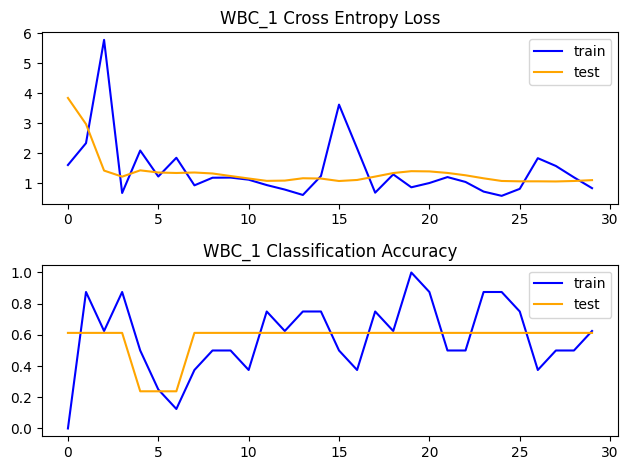

Found 842 images belonging to 5 classes.
Epoch 1/30
13/13 [==============================] - 58s 4s/step - loss: 2.3397 - accuracy: 0.4808 - val_loss: 1.1550 - val_accuracy: 0.6128
Epoch 2/30
13/13 [==============================] - 57s 5s/step - loss: 1.2390 - accuracy: 0.5577 - val_loss: 1.1544 - val_accuracy: 0.6128
Epoch 3/30
13/13 [==============================] - 53s 4s/step - loss: 1.0784 - accuracy: 0.6442 - val_loss: 1.0884 - val_accuracy: 0.6128
Epoch 4/30
13/13 [==============================] - 52s 4s/step - loss: 0.9931 - accuracy: 0.6731 - val_loss: 1.0738 - val_accuracy: 0.6128
Epoch 5/30
13/13 [==============================] - 52s 4s/step - loss: 1.0605 - accuracy: 0.6538 - val_loss: 1.1291 - val_accuracy: 0.6128
Epoch 6/30
13/13 [==============================] - 53s 4s/step - loss: 1.0910 - accuracy: 0.4712 - val_loss: 1.0392 - val_accuracy: 0.6128
Epoch 7/30
13/13 [==============================] - 45s 4s/step - loss: 1.0995 - accuracy: 0.5865 - val_loss: 1.0974 - 

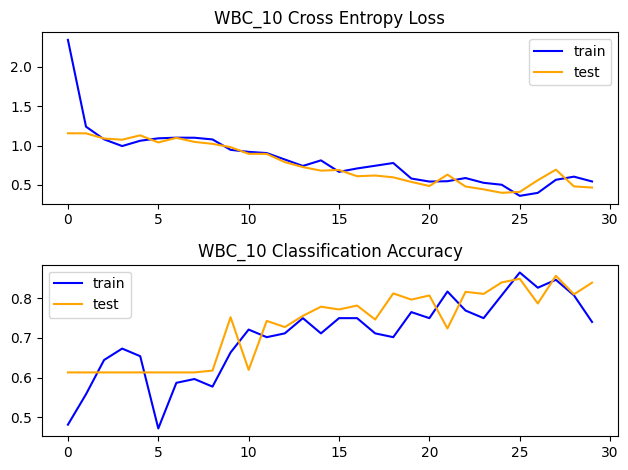

Found 4223 images belonging to 5 classes.
Epoch 1/30
66/66 [==============================] - 88s 1s/step - loss: 1.2799 - accuracy: 0.6212 - val_loss: 1.0502 - val_accuracy: 0.6128
Epoch 2/30
66/66 [==============================] - 89s 1s/step - loss: 0.9558 - accuracy: 0.6319 - val_loss: 0.8277 - val_accuracy: 0.6933
Epoch 3/30
66/66 [==============================] - 87s 1s/step - loss: 0.7813 - accuracy: 0.6970 - val_loss: 0.7332 - val_accuracy: 0.6939
Epoch 4/30
66/66 [==============================] - 82s 1s/step - loss: 0.6695 - accuracy: 0.7424 - val_loss: 0.5830 - val_accuracy: 0.7934
Epoch 5/30
66/66 [==============================] - 89s 1s/step - loss: 0.5219 - accuracy: 0.8068 - val_loss: 0.4676 - val_accuracy: 0.8409
Epoch 6/30
66/66 [==============================] - 86s 1s/step - loss: 0.4372 - accuracy: 0.8390 - val_loss: 0.3397 - val_accuracy: 0.8785
Epoch 7/30
66/66 [==============================] - 82s 1s/step - loss: 0.4193 - accuracy: 0.8239 - val_loss: 0.3152 -

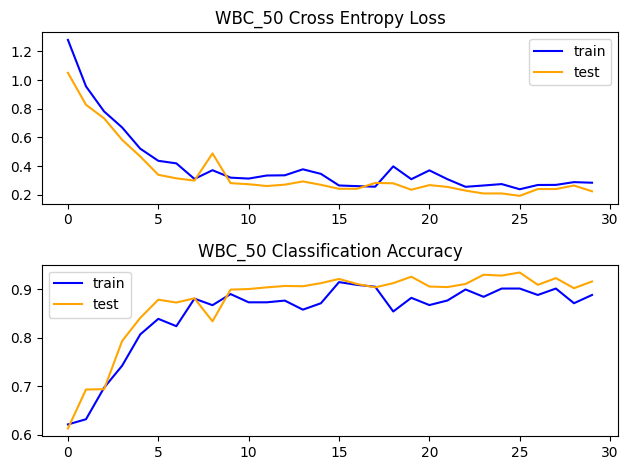

Found 8447 images belonging to 5 classes.
Epoch 1/30
132/132 [==============================] - 329s 2s/step - loss: 1.2220 - accuracy: 0.5720 - val_loss: 1.0743 - val_accuracy: 0.6128
Epoch 2/30
132/132 [==============================] - 298s 2s/step - loss: 0.9328 - accuracy: 0.6676 - val_loss: 0.7185 - val_accuracy: 0.7703
Epoch 3/30
132/132 [==============================] - 269s 2s/step - loss: 0.5890 - accuracy: 0.7992 - val_loss: 0.4416 - val_accuracy: 0.8322
Epoch 4/30
132/132 [==============================] - 252s 2s/step - loss: 0.4385 - accuracy: 0.8314 - val_loss: 0.3642 - val_accuracy: 0.8669
Epoch 5/30
132/132 [==============================] - 272s 2s/step - loss: 0.4050 - accuracy: 0.8445 - val_loss: 0.3722 - val_accuracy: 0.8542
Epoch 6/30
132/132 [==============================] - 201s 2s/step - loss: 0.3822 - accuracy: 0.8598 - val_loss: 0.3227 - val_accuracy: 0.8709
Epoch 7/30
132/132 [==============================] - 243s 2s/step - loss: 0.3761 - accuracy: 0.8550

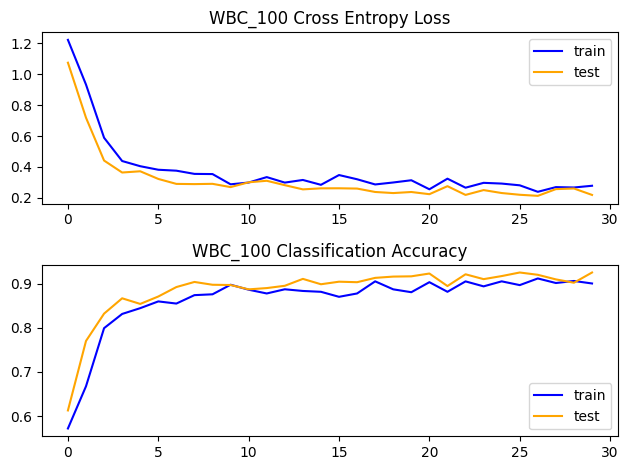

In [ ]:
# Training without additional information
from tensorflow.keras.optimizers.legacy import Adam
nums =['1','10','50','100']
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
i = 0
for WBC in WBCs[i:]:
  train_dir =  dirpath + WBC
    # WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
  train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')

  model = Sequential()
  model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  model.add(Conv2D(32, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(5, activation="softmax"))

  opt = Adam(learning_rate=0.001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])#,options = run_opts)

  # 微调模型
  history = model.fit(train_data_gen,steps_per_epoch=len(train_data_gen)//batch_size, validation_data=val_data_gen, epochs=30)

  _, val_accuracy = model.evaluate(val_data_gen)
  print('Best WBC_' + nums[i] + ' Accuracy: ', max(history.history['accuracy']))
  print('Best WBC_' + nums[i] + ' val Accuracy: ', max(history.history['val_accuracy']))
  print('Average WBC_' + nums[i] + ' val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('WBC_' + nums[i] + ' val Accuracy: ', history.history['val_accuracy'][-1])
  print('Best WBC_' + nums[i] + ' Loss: ', min(history.history['loss']))
  print('Best WBC_' + nums[i] + ' val Loss: ', min(history.history['val_loss']))

  model.save_weights(dirpath+'Models/test/onlyWBC_' + nums[i]+'.h5')
  summarize_diagnostics(history,'WBC_'+nums[i])
  i += 1


Found 7 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 40s 40s/step - loss: 1.6077 - accuracy: 0.1429 - val_loss: 2.3314 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 42s 42s/step - loss: 1.1808 - accuracy: 0.7143 - val_loss: 3.0424 - val_accuracy: 0.2384
Epoch 3/30
1/1 [==============================] - 38s 38s/step - loss: 1.9772 - accuracy: 0.2857 - val_loss: 1.6900 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 42s 42s/step - loss: 0.5736 - accuracy: 0.7143 - val_loss: 1.6627 - val_accuracy: 0.6128
Epoch 5/30
1/1 [==============================] - 42s 42s/step - loss: 0.7438 - accuracy: 0.7143 - val_loss: 1.5176 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 42s 42s/step - loss: 0.6756 - accuracy: 0.7143 - val_loss: 1.3151 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 38s 38s/step - loss: 0.6778 - accuracy: 0.7143 - val_loss: 1.1739 - val_accur

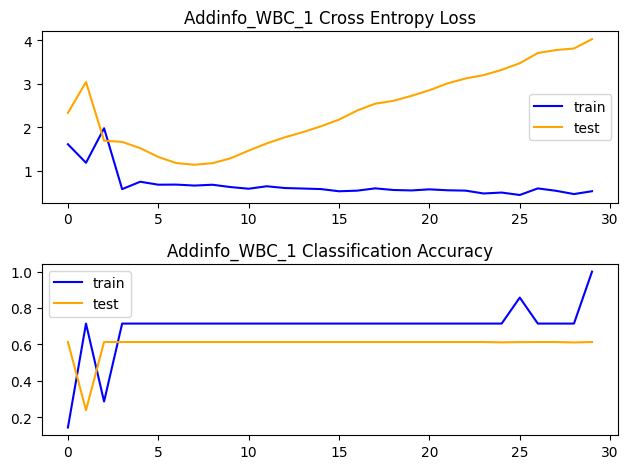

Found 82 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 45s 45s/step - loss: 1.6306 - accuracy: 0.1250 - val_loss: 1.4555 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 43s 43s/step - loss: 1.6330 - accuracy: 0.5000 - val_loss: 2.5576 - val_accuracy: 0.2384
Epoch 3/30
1/1 [==============================] - 44s 44s/step - loss: 2.6398 - accuracy: 0.3750 - val_loss: 1.6668 - val_accuracy: 0.2384
Epoch 4/30
1/1 [==============================] - 42s 42s/step - loss: 2.1845 - accuracy: 0.2500 - val_loss: 1.2222 - val_accuracy: 0.3681
Epoch 5/30
1/1 [==============================] - 38s 38s/step - loss: 0.9729 - accuracy: 0.3750 - val_loss: 1.1899 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 42s 42s/step - loss: 0.6938 - accuracy: 1.0000 - val_loss: 1.1658 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 42s 42s/step - loss: 0.8401 - accuracy: 0.7500 - val_loss: 1.2258 - val_accu

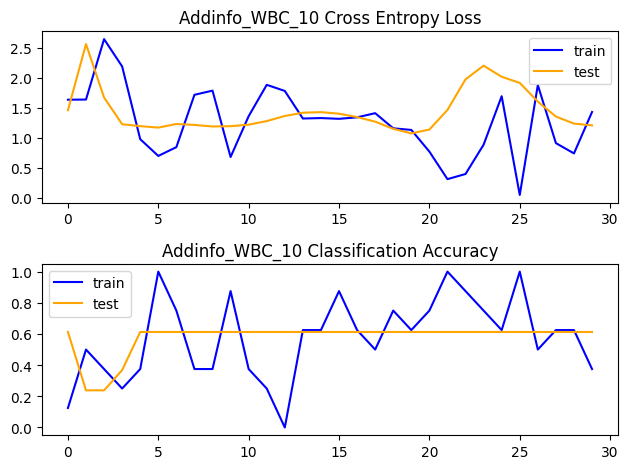

Found 419 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 44s 44s/step - loss: 1.6399 - accuracy: 0.1250 - val_loss: 4.1168 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 85s 85s/step - loss: 6.0719 - accuracy: 0.3750 - val_loss: 2.0625 - val_accuracy: 0.2384
Epoch 3/30
1/1 [==============================] - 44s 44s/step - loss: 2.2771 - accuracy: 0.2500 - val_loss: 1.5155 - val_accuracy: 0.2384
Epoch 4/30
1/1 [==============================] - 43s 43s/step - loss: 0.7682 - accuracy: 0.3750 - val_loss: 1.2369 - val_accuracy: 0.6128
Epoch 5/30
1/1 [==============================] - 44s 44s/step - loss: 0.6458 - accuracy: 0.6250 - val_loss: 1.1968 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 85s 85s/step - loss: 1.6564 - accuracy: 0.7500 - val_loss: 1.1336 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 85s 85s/step - loss: 0.7996 - accuracy: 0.6250 - val_loss: 1.1039 - val_acc

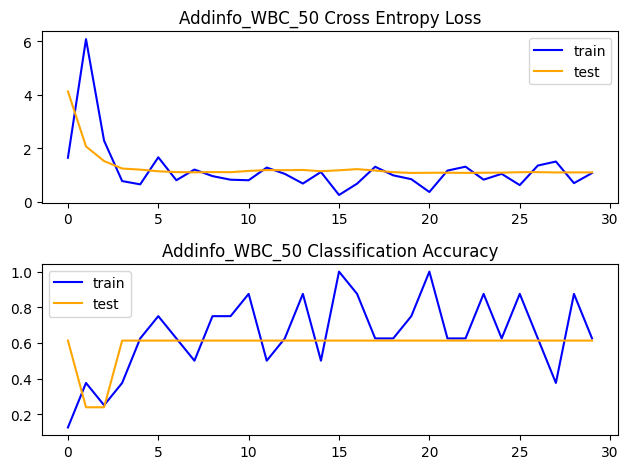

Found 842 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 46s 46s/step - loss: 1.5636 - accuracy: 0.2500 - val_loss: 1.8074 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 49s 49s/step - loss: 0.5741 - accuracy: 0.7500 - val_loss: 2.5834 - val_accuracy: 0.6128
Epoch 3/30
1/1 [==============================] - 52s 52s/step - loss: 1.6396 - accuracy: 0.7500 - val_loss: 2.3412 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 84s 84s/step - loss: 3.1279 - accuracy: 0.5000 - val_loss: 3.7951 - val_accuracy: 0.2384
Epoch 5/30
1/1 [==============================] - 85s 85s/step - loss: 3.3570 - accuracy: 0.1250 - val_loss: 1.6966 - val_accuracy: 0.2384
Epoch 6/30
1/1 [==============================] - 46s 46s/step - loss: 1.8156 - accuracy: 0.5000 - val_loss: 1.2963 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 85s 85s/step - loss: 0.9403 - accuracy: 0.6250 - val_loss: 1.2278 - val_acc

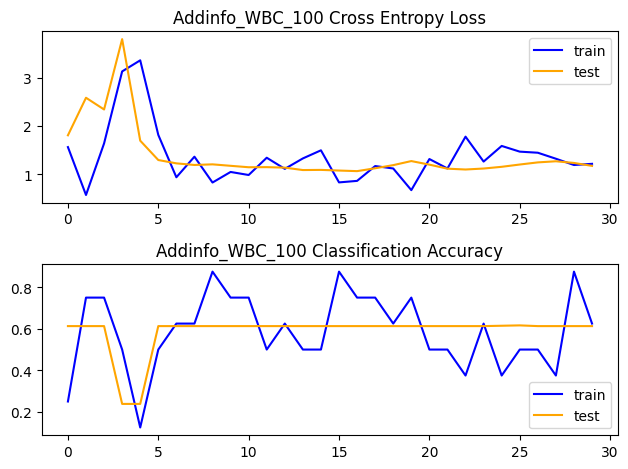

In [31]:
# Train only masked images
from tensorflow.keras.optimizers.legacy import Adam
nums =['1','10','50','100']
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
processeds = [r'WBC_1/processed/',r'WBC_10/processed/',r'WBC_50/processed/',r'WBC_100/train/processed/']
i = 0
for WBC in processeds[i:]:
  pre_train_dir =  dirpath + WBC
    # WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
  processed_train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=pre_train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')

  model = Sequential()
  model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  model.add(Conv2D(32, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(5, activation="softmax"))

  opt = Adam(learning_rate=0.001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])#,options = run_opts)

  history = model.fit(processed_train_data_gen,steps_per_epoch=len(processed_train_data_gen)//batch_size, validation_data=val_data_gen, epochs=30)

  _, val_accuracy = model.evaluate(val_data_gen)
  print('Best WBC_' + nums[i] + ' Accuracy: ', max(history.history['accuracy']))
  print('Best WBC_' + nums[i] + ' val Accuracy: ', max(history.history['val_accuracy']))
  print('Average WBC_' + nums[i] + ' val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('WBC_' + nums[i] + ' val Accuracy: ', history.history['val_accuracy'][-1])
  print('Best WBC_' + nums[i] + ' Loss: ', min(history.history['loss']))
  print('Best WBC_' + nums[i] + ' val Loss: ', min(history.history['val_loss']))

  model.save_weights(dirpath+'Models/Use_mask/Addinfo_WBC_' + nums[i]+'.h5')
  summarize_diagnostics(history,'Addinfo_WBC_'+nums[i])
  i += 1


Found 82 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 88s 88s/step - loss: 1.5807 - accuracy: 0.2500 - val_loss: 4.1641 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 83s 83s/step - loss: 2.4491 - accuracy: 0.8750 - val_loss: 3.3125 - val_accuracy: 0.6128
Epoch 3/30
1/1 [==============================] - 42s 42s/step - loss: 7.6800 - accuracy: 0.5000 - val_loss: 1.4419 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 44s 44s/step - loss: 0.6585 - accuracy: 0.7500 - val_loss: 1.8510 - val_accuracy: 0.2384
Epoch 5/30
1/1 [==============================] - 41s 41s/step - loss: 5.9161 - accuracy: 0.0000e+00 - val_loss: 1.4680 - val_accuracy: 0.2384
Epoch 6/30
1/1 [==============================] - 43s 43s/step - loss: 1.7584 - accuracy: 0.3750 - val_loss: 1.2680 - val_accuracy: 0.2384
Epoch 7/30
1/1 [==============================] - 42s 42s/step - loss: 1.5740 - accuracy: 0.0000e+00 - val_loss: 1.2188 - 

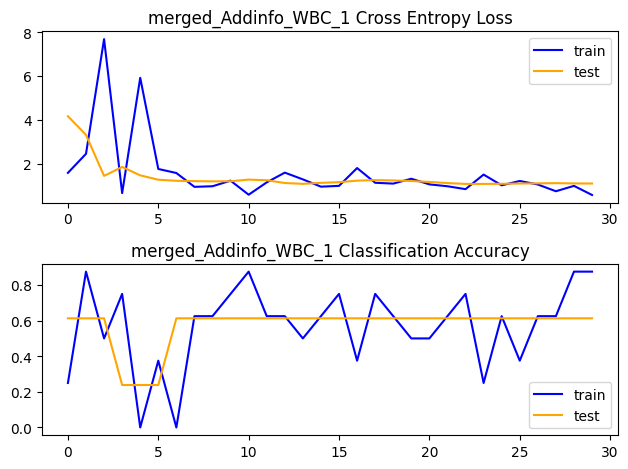

Found 842 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 46s 46s/step - loss: 1.3888 - accuracy: 0.8750 - val_loss: 2.2623 - val_accuracy: 0.2390
Epoch 2/30
1/1 [==============================] - 44s 44s/step - loss: 6.6251 - accuracy: 0.3750 - val_loss: 4.6032 - val_accuracy: 0.6128
Epoch 3/30
1/1 [==============================] - 44s 44s/step - loss: 9.3517 - accuracy: 0.6250 - val_loss: 3.1297 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 44s 44s/step - loss: 6.0811 - accuracy: 0.6250 - val_loss: 2.2077 - val_accuracy: 0.0550
Epoch 5/30
1/1 [==============================] - 86s 86s/step - loss: 2.8905 - accuracy: 0.1250 - val_loss: 1.5424 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 43s 43s/step - loss: 1.5791 - accuracy: 0.7500 - val_loss: 1.4465 - val_accuracy: 0.0741
Epoch 7/30
1/1 [==============================] - 44s 44s/step - loss: 1.1756 - accuracy: 0.1250 - val_loss: 1.3156 - val_acc

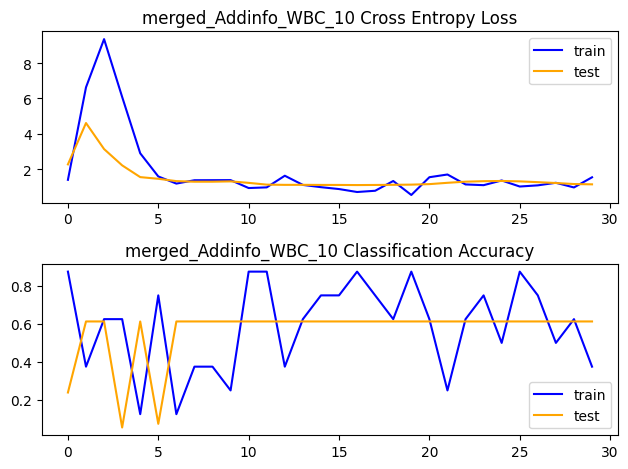

Found 4223 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 87s 87s/step - loss: 1.6642 - accuracy: 0.2500 - val_loss: 3.1224 - val_accuracy: 0.2384
Epoch 2/30
1/1 [==============================] - 86s 86s/step - loss: 8.8148 - accuracy: 0.1250 - val_loss: 3.0703 - val_accuracy: 0.6128
Epoch 3/30
1/1 [==============================] - 45s 45s/step - loss: 1.8230 - accuracy: 0.7500 - val_loss: 2.9145 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 85s 85s/step - loss: 9.3258 - accuracy: 0.3750 - val_loss: 1.8246 - val_accuracy: 0.6128
Epoch 5/30
1/1 [==============================] - 47s 47s/step - loss: 6.3557 - accuracy: 0.3750 - val_loss: 1.1510 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 88s 88s/step - loss: 3.0222 - accuracy: 0.3750 - val_loss: 1.2476 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 45s 45s/step - loss: 1.1182 - accuracy: 0.6250 - val_loss: 1.4677 - val_ac

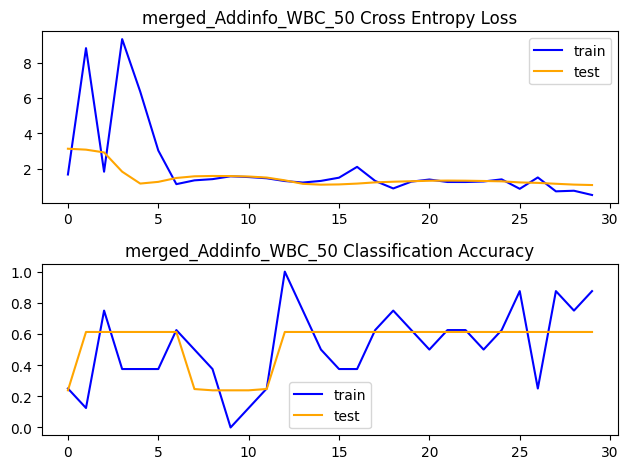

Found 8447 images belonging to 5 classes.
Epoch 1/30
1/1 [==============================] - 87s 87s/step - loss: 1.5247 - accuracy: 0.2500 - val_loss: 1.6500 - val_accuracy: 0.6128
Epoch 2/30
1/1 [==============================] - 85s 85s/step - loss: 4.1638 - accuracy: 0.5000 - val_loss: 3.5468 - val_accuracy: 0.2384
Epoch 3/30
1/1 [==============================] - 85s 85s/step - loss: 8.0291 - accuracy: 0.1250 - val_loss: 1.1046 - val_accuracy: 0.6128
Epoch 4/30
1/1 [==============================] - 86s 86s/step - loss: 1.3187 - accuracy: 0.6250 - val_loss: 1.1285 - val_accuracy: 0.6128
Epoch 5/30
1/1 [==============================] - 86s 86s/step - loss: 0.8218 - accuracy: 0.7500 - val_loss: 1.1873 - val_accuracy: 0.6128
Epoch 6/30
1/1 [==============================] - 86s 86s/step - loss: 0.9182 - accuracy: 0.7500 - val_loss: 1.2365 - val_accuracy: 0.6128
Epoch 7/30
1/1 [==============================] - 85s 85s/step - loss: 0.9900 - accuracy: 0.7500 - val_loss: 1.2526 - val_ac

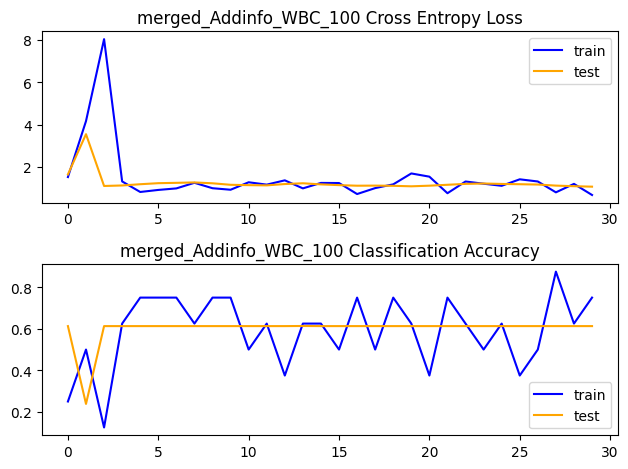

In [33]:
# merge 2 datasets
from tensorflow.keras.optimizers.legacy import Adam
dirpath2 = '/content/drive/MyDrive/CS5242/Project/Processed_Data/'
nums =['1','10','50','100']
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
processeds = [r'WBC_1/processed/',r'WBC_10/processed/',r'WBC_50/processed/',r'WBC_100/train/processed/']
i = 0
for WBC in WBCs[i:]:
  pre_train_dir =  dirpath2 + WBC
    # WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
  processed_train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=pre_train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')

  model = Sequential()
  model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  model.add(Conv2D(32, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(5, activation="softmax"))

  opt = Adam(learning_rate=0.001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])#,options = run_opts)

  # 微调模型
  history = model.fit(processed_train_data_gen,steps_per_epoch=len(train_data_gen)//batch_size, validation_data=val_data_gen, epochs=30)

  _, val_accuracy = model.evaluate(val_data_gen)
  print('Best WBC_' + nums[i] + ' w/ add info Accuracy: ', max(history.history['accuracy']))
  print('Best WBC_' + nums[i] + ' w/ add info val Accuracy: ', max(history.history['val_accuracy']))
  print('Average WBC_' + nums[i] + ' w/ add info val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('Average WBC_' + nums[i] + ' w/ add info val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('WBC_' + nums[i] + ' w/ add info Accuracy: ', history.history['accuracy'][-1])
  print('WBC_' + nums[i] + ' w/ add info val Accuracy: ', history.history['val_accuracy'][-1])
  print('Best WBC_' + nums[i] + 'w/ add info Loss: ', min(history.history['loss']))
  print('Best WBC_' + nums[i] + 'w/ add info val Loss: ', min(history.history['val_loss']))

  model.save_weights(dirpath+'Models/Merged_wi_mask/merged_Addinfo_WBC_' + nums[i]+'.h5')
  summarize_diagnostics(history,'merged_Addinfo_WBC_'+nums[i])
  i += 1


Below are all reference trying codes, which do not return reasonable result, I will analyze in my report from my side.

In [7]:
batch_size=32
input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_input_tensor = Input(shape=(CAM_SIZE, CAM_SIZE, 3))
base_model = ResNet50(input_tensor=pre_input_tensor, include_top=False, weights=None)

###
pre_train_model = Sequential()

pre_train_model.add(base_model)
pre_train_model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
pre_train_model.add(MaxPooling2D())
pre_train_model.add(Dropout(0.5))
pre_train_model.add(GlobalAveragePooling2D())
pre_train_model.add(Dense(128, activation='sigmoid'))
pre_train_model.add(Dense(2, activation='softmax'))
pre_train_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
pre_train_history = pre_train_model.fit(pre_train_data_gen,steps_per_epoch=len(pre_train_data_gen)//batch_size, validation_data=pre_val_data_gen, epochs=300)
###

###
# x = GlobalAveragePooling2D()(base_model.output)  # 添加全局平均池化层
# x = Dense(1024, activation='relu')(x)  # 添加一个全连接层
# predictions = Dense(2, activation='softmax')(x)
# pre_train_model = Model(inputs=base_model.input, outputs=predictions)

# pre_train_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# pre_train_history = pre_train_model.fit(pre_train_data_gen,steps_per_epoch=len(pre_train_data_gen)//batch_size, validation_data=pre_val_data_gen, epochs=300)

# for layer in base_model.layers:
#     layer.trainable = False

###

# x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(1024, activation='relu')(x)  # 添加一个全连接层
# x = Dense(2, activation='softmax')(x)  # 两个类别
# pre_train_model = Model(inputs=pre_input_tensor, outputs=x)

# opt = Adam(learning_rate=0.001)
# pre_train_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# pre_train_history = pre_train_model.fit(pre_train_data_gen,steps_per_epoch=len(pre_train_data_gen)//batch_size, validation_data=pre_val_data_gen, epochs=30)

# pre_train_model.save_weights('pre_train_model.h5')


Epoch 1/300
2/2 [==============================] - 93s 45s/step - loss: 0.7877 - accuracy: 0.3125 - val_loss: 0.7175 - val_accuracy: 0.5000
Epoch 2/300
2/2 [==============================] - 4s 3s/step - loss: 0.6114 - accuracy: 0.7500 - val_loss: 0.7167 - val_accuracy: 0.5000
Epoch 3/300
2/2 [==============================] - 5s 3s/step - loss: 0.8599 - accuracy: 0.3125 - val_loss: 0.7181 - val_accuracy: 0.5000
Epoch 4/300
2/2 [==============================] - 4s 3s/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 5/300
2/2 [==============================] - 3s 2s/step - loss: 0.6351 - accuracy: 0.8125 - val_loss: 0.7182 - val_accuracy: 0.5000
Epoch 6/300
2/2 [==============================] - 4s 4s/step - loss: 0.6679 - accuracy: 0.5625 - val_loss: 0.7144 - val_accuracy: 0.5000
Epoch 7/300
2/2 [==============================] - 4s 3s/step - loss: 0.7291 - accuracy: 0.5000 - val_loss: 0.7112 - val_accuracy: 0.5000
Epoch 8/300
2/2 [===============

In [8]:
dir_pretrain = dirpath + 'Models/pre_train/'
# pre_train_model.save_weights('pre_train_model.h5')
# pre_train_model.save_weights(dirpath+'Models/pre_train/pre_train_model.h5' + nums[i]+'.h5')
pre_train_model.save_weights(dir_pretrain+'pre_train_model.h5')
#summarize_diagnostics(history,'pre_train'+nums[i])

In [ ]:
# merge 2 datasets, with pretrained model
batch_size = 8
nums =['1','10','50','100']
dirpath2 = '/content/drive/MyDrive/CS5242/Project/Processed_Data/'
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
processeds = [r'WBC_1/processed/',r'WBC_10/processed/',r'WBC_50/processed/',r'WBC_100/train/processed/']
i = 0
for WBC in WBCs[i:]:
  pre_train_dir =  dirpath2 + WBC
  # print(pre_train_dir)
    # WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
  processed_train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=pre_train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')

  for layer in base_model.layers:
    layer.trainable = False
  x = pre_train_model.layers[-2].output
  # x = GlobalAveragePooling2D()(pre_train_model.layers[-3].output)
  # x = Dense(1024, activation='relu')(x)  # 添加一个全连接层
  x = Dense(5, activation='softmax')(x)  # 两个类别
  model = Model(inputs=pre_train_model.input, outputs=x)

  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(processed_train_data_gen,steps_per_epoch=len(processed_train_data_gen)//batch_size, validation_data=val_data_gen, epochs=30)

  _, val_accuracy = model.evaluate(val_data_gen)
  print('Best pretrain WBC_' + nums[i] + ' w/ add info Accuracy: ', max(history.history['accuracy']))
  print('Best pretrain WBC_' + nums[i] + ' w/ add info val Accuracy: ', max(history.history['val_accuracy']))
  print('Average pretrain WBC_' + nums[i] + ' w/ add info Accuracy: ', sum(history.history['accuracy'])/len(history.history['accuracy']))
  print('Average pretrain WBC_' + nums[i] + ' w/ add info val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('pretrain WBC_' + nums[i] + ' w/ add info Accuracy: ', history.history['accuracy'][-1])
  print('pretrain WBC_' + nums[i] + ' w/ add info val Accuracy: ', history.history['val_accuracy'][-1])
  print('Best pretrain WBC_' + nums[i] + 'w/ add info Loss: ', min(history.history['loss']))
  print('Best pretrain WBC_' + nums[i] + 'w/ add info val Loss: ', min(history.history['val_loss']))

  model.save_weights(dirpath+'Models/pre_train/pretrain_WBC_' + nums[i]+'.h5')
  summarize_diagnostics(history,'pretrain_WBC_'+nums[i])
  i += 1



Found 82 images belonging to 5 classes.
Epoch 1/30


1/1 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+00

In [ ]:
# Use 2 branches to train raw_image and masked_image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
# def model_layers():
#   input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="raw_image_input")
#   # mask_image_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name="mask_image_input")
#   layers = Conv2D(32, 3, padding="same", activation="relu")(input_layer)
#   layers = MaxPooling2D()(layers)
#   layers = Dropout(0.2)(layers)
#   layers = Conv2D(32, 3, padding="same", activation="relu")(layers)

#   layers = MaxPooling2D()(layers)

#   layers = Conv2D(64, 3, padding="same", activation="relu")(layers)
#   layers = MaxPooling2D()(layers)
#   layers = Dropout(0.4)(layers)

#   layers = Flatten()(layers)
#   return layers

def create_image_model():
    model = Sequential()
    model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    return model

# Define a function to create the combined model using raw and masked image models.
def create_combined_model():
    # input_shape = (image_height, image_width, image_channels)  # Adjust as per your data.

    raw_image_model = create_image_model()
    masked_image_model = create_image_model()

    # Concatenate the output of both models
    combined = concatenate([raw_image_model.output, masked_image_model.output])

    # Add fully connected layers for classification
    combined = Flatten()(combined)
    combined = Dense(128, activation='sigmoid')(combined)
    output = Dense(5, activation='softmax')(combined)  # 5 classes

    model = Model(inputs=[raw_image_model.input, masked_image_model.input], outputs=output)
    return model

nums =['1','10','50','100']
WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
processeds = [r'WBC_1/processed/',r'WBC_10/processed/',r'WBC_50/processed/',r'WBC_100/train/processed/']
j = 3
weight_raw = 0.5
weight_mask = 1


for i in range(j,len(WBCs)):
  pre_train_dir =  dirpath + processeds[j]
  train_dir = dirpath + WBCs[j]
    # WBCs = [r'WBC_1/data/',r'WBC_10/data/',r'WBC_50/data/',r'WBC_100/train/data/']
  processed_train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=pre_train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')
  train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                      directory=train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='sparse')
  # print(processed_train_data_gen)
  # print(train_data_gen)
  print(val_data_gen)

  model = create_combined_model()
  opt = Adam(learning_rate=0.001)

  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])#,options = run_opts)

  # 微调模型
  history = model.fit([train_data_gen, processed_train_data_gen], validation_data=[val_data_gen,val_data_gen], epochs=30)

  _, val_accuracy = model.evaluate([val_data_gen,val_data_gen])
  print('Best WBC_' + nums[i] + ' Accuracy: ', max(history.history['accuracy']))
  print('Best WBC_' + nums[i] + ' val Accuracy: ', max(history.history['val_accuracy']))
  print('Average WBC_' + nums[i] + ' val Accuracy: ', sum(history.history['val_accuracy'])/len(history.history['val_accuracy']))
  print('WBC_' + nums[i] + ' val Accuracy: ', history.history['val_accuracy'][-1])
  print('Best WBC_' + nums[i] + ' Loss: ', min(history.history['loss']))
  print('Best WBC_' + nums[i] + ' val Loss: ', min(history.history['val_loss']))

  model.save_weights(dirpath+'Models/Use_mask2/Addinfo_WBC_' + nums[i]+'.h5')
  summarize_diagnostics(history,'Addinfo_WBC_'+nums[i])
  #i += 1

